In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import pandas as pd
from sklearn import preprocessing
import GPy
from tqdm import tqdm

#### Initial testing to generate the figures in fig1

In [3]:
#8*1000 random vars, 8 input vectors/features
xjs_unif = np.random.uniform(-1.,1.,(8,300))
xjs_norm = np.random.normal(0,0.4,(8,300))

#8 uniform coefficients of sine function for the 8 functions
phi = np.linspace(np.pi/10,np.pi,8)

#compute input of sines = phij*xj for each j
inp_unif = []
inp_norm = []
for i in range(8):
    inp_unif.append(phi[i]*xjs_unif[i,:])
    inp_norm.append(phi[i]*xjs_norm[i,:])
inp_unif = np.array(inp_unif)
inp_norm = np.array(inp_norm)
sines_unif = np.sin(inp_unif)
sines_norm = np.sin(inp_norm)

#compute function coeffs Aj by finding the std of sin(phij*xj) and taking 1/std(sin(phij*xj))
fjunif = []
fjnorm = []
for i in range(8):
    fjunif.append(sines_unif[i,:]/np.std(sines_unif[i,:]))
    fjnorm.append(sines_norm[i,:]/np.std(sines_norm[i,:]))
fjunif = np.array(fjunif)
fjnorm = np.array(fjnorm)

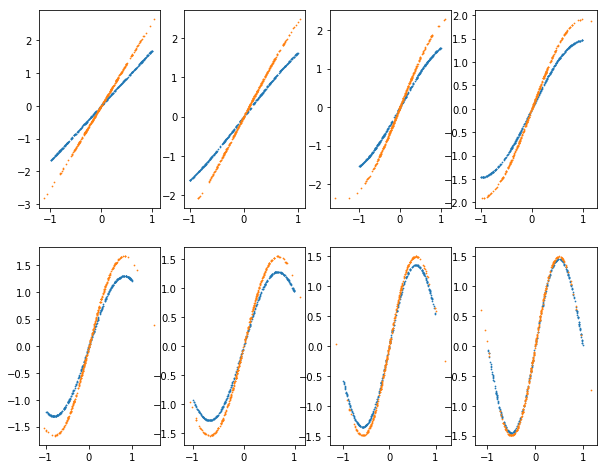

In [4]:
fig,ax = plt.subplots(2,4,figsize=(10,8))
ax = ax.ravel()
for i in range(8):
    ax[i].scatter(xjs_unif[i,:],fjunif[i,:],s=0.5)
    ax[i].scatter(xjs_norm[i,:],fjnorm[i,:],s=0.5)

#### Implementation of algo + plots of fig2 only done on Uniform x data

In [5]:
#KL divergence
def KL(mu1,s1,mu2,s2):
    return (np.log(s2/s1) +(s1**2+(mu1-mu2)**2)/(2*s2**2)- 1./2)

#relevance metric
def rrel_fun(mu1,s1,mu2,s2):
    return (np.sqrt(2*KL(mu1,s1,mu2,s2))/delta)


In [6]:
#vectors to store 2 types of relevance measures over the 200 repeated experiments
ARD200 = np.zeros((200,8))
KL200 = np.zeros((200,8))
for looper in tqdm(range(200)):
    #8*1000 random vars, 8 input vectors/features
    xjs_unif = np.random.uniform(-1.,1.,(8,300))
    #8 uniform coefficients of sine function for the 8 functions
    phi = np.linspace(np.pi/10,np.pi,8)
    #compute input of sines = phij*xj for each j
    inp_unif = []
    for i in range(8):
        inp_unif.append(phi[i]*xjs_unif[i,:])
    inp_unif = np.array(inp_unif)
    sines_unif = np.sin(inp_unif)
    #compute function coeffs Aj by finding the std of sin(phij*xj) and taking 1/std(sin(phij*xj))
    fjunif = []
    for i in range(8):
        fjunif.append(sines_unif[i,:]/np.std(sines_unif[i,:]))
    fjunif = np.array(fjunif)

    #this is a multidimensional Yvector, the plot will not make sense
    yvar = 0
    for i in range(8):
        yvar = yvar + fjunif[i,:]
    noisevec = np.random.normal(0,0.3,300) 
    yvar = yvar + noisevec
    yvar = np.array([yvar])
    #scale the input to have unit variance so delta is fixed
    X_scaled = preprocessing.scale(xjs_unif.T)
    # define kernel
    ker = GPy.kern.RBF(input_dim=8,variance=1.,lengthscale=np.ones(8),ARD=True) + GPy.kern.White(8)
    # create simple GP model
    m = GPy.models.GPRegression(X_scaled,yvar.T,ker)
    # optimize and plot
    m.optimize(messages=False,max_f_eval = 100)
    ARD200[looper,:] = m.sum.rbf.lengthscale.values
    #predict at the training points, predict returns mu and variance!
    muorig,varorig = m.predict(X_scaled)
    delta = 0.0001
    #calculate relevance by comparing predictive dist at x and x+delta (delta added to one column only)
    rels = np.zeros((300,8))
    for i in range(8):
        xu = np.copy(X_scaled)
        xu[:,i] = xu[:,i] + delta
        muu,Cu = m.predict(xu)
        rels[:,i] = rrel_fun(muorig,np.sqrt(varorig),muu,np.sqrt(Cu)).ravel()
    KL200[looper,:] = rels.mean(axis=0)
        
    

100%|██████████| 200/200 [12:55<00:00,  3.88s/it]


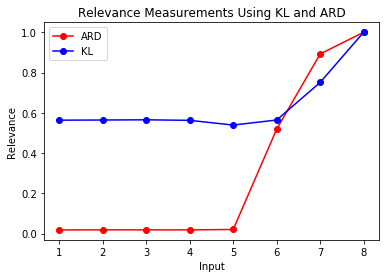

In [7]:
ardvec = 1/(ARD200.mean(axis=0))
KLvec = KL200.mean(axis=0)
plt.plot(range(1,9),ardvec/ardvec.max(),'ro-',label='ARD')
plt.plot(range(1,9),KLvec/KLvec.max(),'bo-',label='KL')
plt.xlabel('Input')
plt.ylabel('Relevance')
plt.title('Relevance Measurements Using KL and ARD')
plt.legend()
plt.show()